# Exercise 5: Forecasting

Here we will practice using our model as a forecasting tool. We will fit the model to the initial part of our plague dataset and see whether the model succeeds in predicting the later parts of the plague dataset.

## Set up

In [1]:
# Load libraries
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

# Use scipy.optimize.minimize to mnimizes sum of squared errors function
from scipy.optimize import minimize

In [2]:
%matplotlib inline

In [3]:
# Load plague Data
plague_dat = pd.read_csv('../../plague_data.csv')
plague_dat['time'] = plague_dat.index.values

plague_dat.head()

,Week_of_year,Deaths,time
0,39,31,0
1,40,18,1
2,41,12,2
3,42,9,3
4,43,13,4


In [4]:
# Define a function for numerically integrating the SIR model
def sir_model(state, time, parameters):
    # Unpack Parameters
    S, I, R = state
    beta, gamma = parameters
    
    # Calculate total population size
    N = S + I + R
    
    # Calculate force of infection
    lambd = beta * I / N
    
    # Calculate derivatives
    dS = -lambd * S
    dI = lambd * S - gamma * I
    dR = gamma * I
    
    # Return derivative
    return [dS, dI, dR]

In [5]:
# Using the fit values from before, generate a "baseline solution" to the model

# Using the optimized parameter values from before
parameters = {'beta': 2.67546942, 'gamma': 2.20012301}

# Define times - start at week 10
times = np.arange(10, 55, 1)


# Initial state values
initial_state_values = [55000 - 1, 1, 0]

sir_fit = odeint(sir_model, initial_state_values, times, args=(list(parameters.values()),))
sir_fit = pd.DataFrame(sir_fit, columns=['S', 'I', 'R'])
sir_fit['time'] = times


# Fit model to partial data

This will look very similar to what we did in exercise 3, but using a subset of our data.


Define cost function

In [6]:
def sir_sse(parameters, times, dat):
    # Calculate model output
    output = odeint(sir_model, initial_state_values, times, args=(parameters,))
    output = pd.DataFrame(output, columns=['S', 'I', 'R'])
    output['time'] = output.index + 10 # plus nine, because we are going to start on week 10
    
    # Merge with data
    output = pd.merge(output, dat, on='time')
    
    # Calculate sum of squared errors (SSE)
    output['sse'] = (output['I'] - output['Deaths'])**2
    
    sse = output['sse'].sum()
    
    return sse

Isolate the first data points from week 10 through week 20 in the plague dataset, and re-run the calibration from Exercise 3

In [7]:
# Create a new dataset which only includes the first 20 data points
plague_dat_initial = plague_dat[:20]


In [8]:
parameters = {'beta': 1.0, 'gamma': 0.5}

# Define times - start at week 10 and end at week 20
times = np.arange(10, 20, 1)

# Initial state values
initial_state_values = [54999, 1, 0]

# Perform the minimization of Sum of Squared Errors
fitval = minimize(sir_sse, x0=list(parameters.values()), args=(times, plague_dat_initial,), method='BFGS')

# Parameter values from the optimization:
fitval_params = fitval.x

Here are the forecast model's estimates of $\beta$ and $\gamma$

In [9]:
fitval_params

array([8.89502363, 8.27198987])

Next, use the values of beta and gamma to forecast the rest of the outbreak:

In [10]:
# Define times - start at week 10
times = np.arange(10, 55, 1)

# Initial state values
initial_state_values = [55000 - 1, 1, 0]

# Solve the forecast model
sir_forecast = odeint(sir_model, initial_state_values, times, args=(list(fitval_params),))
sir_forecast = pd.DataFrame(sir_forecast, columns=['S', 'I', 'R'])
sir_forecast['time'] = times

sir_forecast = pd.DataFrame(sir_forecast)

Also, use the values of beta and gamma from Exercise 3 so we can compare our full data fit model against the forecast model

In [11]:
# Solve the model with the optimized parameters
sir_fit = odeint(sir_model, initial_state_values, times, args=([2.67546942, 2.20012301],))
sir_fit = pd.DataFrame(sir_fit, columns=['S', 'I', 'R'])
sir_fit['time'] = times

In [ ]:
Create a plot

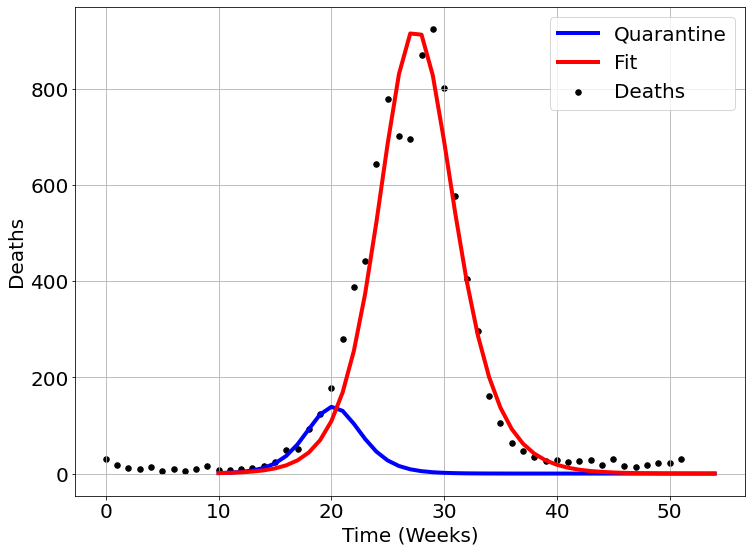

In [12]:
# Create a plot
plt.figure(figsize = (12,9))
plt.plot(sir_forecast['time'], sir_forecast['I'], color='blue', linewidth=4, label='Quarantine')
plt.plot(sir_fit['time'], sir_fit['I'], color='red', linewidth=4, label='Fit')
plt.scatter(plague_dat['time'], plague_dat['Deaths'], color='black', s=30, label='Deaths')
plt.xlabel("Time (Weeks)",fontsize = 20)
plt.ylabel("Deaths",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

## Question: Predicted Deaths

How many deaths does the forecast model predict will occur during the outbreak?

In [13]:
list(sir_forecast['R'])[-1]

7532.51164224665

How does that compare to the number of people who became infected before?

The difference between these two counts reflects the accuracy of your forecast.


In [14]:
list(sir_fit['R'])[-1]

18314.532053687297

## Question: R_0
What is R0 for your forecast model fit to only the first few data points?


In [15]:
fitval_params[0]/fitval_params[1]

1.075318486267243

What was R0 for your model fit to all of the data points

In [16]:
2.67546942/2.2001230

1.2160544751361628

How do these two values of R0 compare? How is this reflected in the differences between your forecasted model and the original model?

## Optional Question: Improving the forecast
Think of ways that you can make your forecast better. 

What happens to the forecast you change the initial parameter guess to the same values as in the original model (beta = 2.559, gamma = 2.109)?

In [19]:
sir_forecast["R"].values[-1]

7532.51164224665

How does that compare to the number of people who became infected before?

In [18]:
sir_fit["R"].values[-1]

18314.532053687297

## Question : stopping an outbreak with quarantine
Try adjusting p_quarantine: how large does it need to be in order to stop an outbreak from occurring?


## Optional question: Improving the forecast

In this new quarantine scenario, we have altered the structure of our model.

Find an expression for R_0 as a function of beta, gamma, and p_quarantine. Solve for p_quarantine such that R_0 = 1. Compare the value of p_quarantine to the value that you found which was high enough to stop an outbreak from occurring.


# Optional Question: Parameter Uncertainty

Imagine that your parameter values have some uncertainty to them, and that they can range according to a uniform distribution with width +/- 10%. From this we can imagine a range of possible future outcomes: The uncertainty in our parameters translates into uncertainty in our forecast outcomes.

First, create a list of parameter combinations

In [20]:
fit_forecast_pars = np.array([
    np.random.uniform(fitval_params[0]*.9, fitval_params[0]*1.1, 100),
    np.random.uniform(fitval_params[1]*.9, fitval_params[1]*1.1, 100)]
).T

Loop over each parameter combination: create a set of datapoints for each parameter combination


In [21]:
for i in range(100):
    params = fit_forecast_pars[i]
    sir_forecast_draw = odeint(sir_model, initial_state_values, times, args=(params,))
    sir_forecast_draw = pd.DataFrame(sir_forecast_draw, columns=['S', 'I', 'R'])
    sir_forecast_draw['time'] = times
    sir_forecast_draw['run'] = i
    
    if i == 0:
        sir_forecast_draws = sir_forecast_draw
    else:
        sir_forecast_draws = pd.concat([sir_forecast_draws, sir_forecast_draw], axis = 0)

Plot!

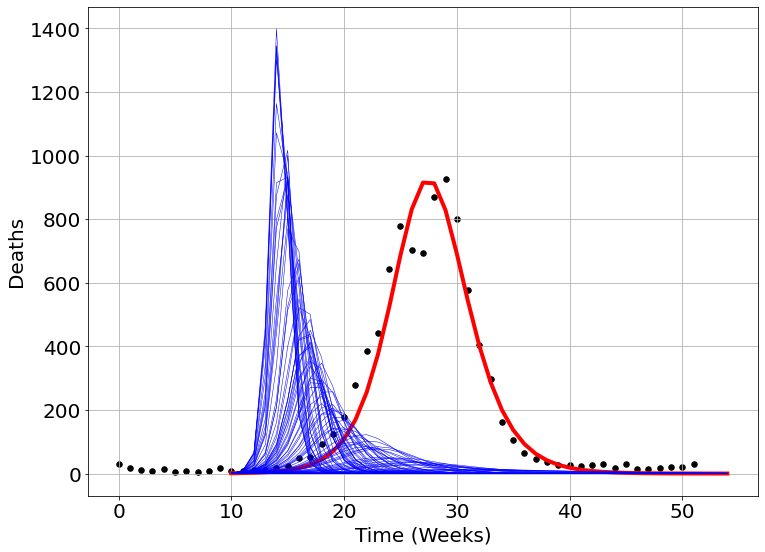

In [22]:
# Create a plot
plt.figure(figsize = (12,9))
plt.plot(sir_fit['time'], sir_fit['I'], color='red', linewidth=4, label='Quarantine')

for i in range(100):
    plt.plot(sir_forecast_draws[sir_forecast_draws['run'] == i].loc[:,"time"].values, 
             sir_forecast_draws[sir_forecast_draws['run'] == i].loc[:,"I"].values, color='blue', linewidth=.5, label='Fit')

plt.scatter(plague_dat['time'], plague_dat['Deaths'], color='black', s=30, label='Deaths')
plt.xlabel("Time (Weeks)",fontsize = 20)
plt.ylabel("Deaths",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

Describe what you see - how big is the variation in the range of possible outputs? Are there systematic failures in the forecast with the uncertainties we have used for our parameter values?



# Optional Exercise: How initial data affects forecasting
Try creating a new forecast, this time with fewer initial data points.